# Background

Perhaps you've played [Twenty Questions](https://en.wikipedia.org/wiki/Twenty_Questions) before:  it's a game where one player (the _answerer_) thinks of a person, place, or thing, and other players ask yes-or-no questions to guess the object of the answerer's thoughts.  Since the answerer probably knows about a lot of different people and objects, a good strategy for the other players involves devising questions that reduce the space of possible answers as much as possible no matter how they are answered.  

Given a labeled collection of examples, you might imagine a technique to [learn a _decision tree_](https://en.wikipedia.org/wiki/Decision_tree_learning) of questions to classify these examples by asking as few questions as possible.  However, you might imagine that such a technique would necessarily be quite dependent on the exact examples on offer.  (In other words,  these techniques are prone to _overfitting_.)  As a simple illustration,  consider the case where your set of example objects was `{ 'ant', 'elephant'}`.  In this case, the question "is it smaller than a typical adult human" would enable you to differentiate between examples optimally.   However, that question would be useless if our set of example objects was the set of all domesticated dog breeds.

[Random decision forest models](https://en.wikipedia.org/wiki/Random_forest) work by training an _ensemble_ of imprecise decision trees that only consider subsets of features or examples and then aggregating the results from the ensemble.  By learning and aggregating an ensemble of trees, random decision forests can be more accurate than individual decision trees _and_ are less likely to overfit.  In this notebook, we'll use a random decision forest to classify documents as either "spam" (based on food reviews) or "legitimate" (based on Jane Austen).

In [1]:
import pandas as pd

import pandas as pd

features = pd.read_parquet("data/features.parquet")

In [2]:
features.sample(5)

,index,label,0,1,2,3,4,5,6,7,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
24467,4467,spam,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33163,13163,spam,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38724,18724,spam,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24609,4609,spam,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1606,1606,legitimate,0.166678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection

train, test = model_selection.train_test_split(features)

rfc = RandomForestClassifier(n_estimators=25)

/anaconda2/envs/mlworkflow/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
rfc.fit(X=train.iloc[:,2:train.shape[1]], y=train["label"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [5]:
from mlworkflows import plot

predictions = rfc.predict(test.iloc[:,2:train.shape[1]])
df, chart = plot.binary_confusion_matrix(test["label"], predictions)

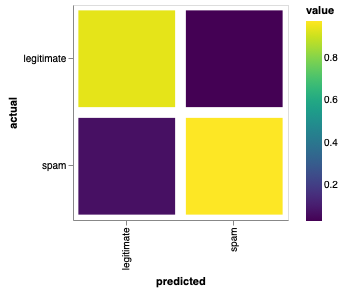

In [6]:
chart

In [7]:
df

,actual,predicted,raw_count,value
0,legitimate,legitimate,4670,0.934935
1,spam,legitimate,325,0.065065
2,legitimate,spam,129,0.025774
3,spam,spam,4876,0.974226


One interesting aspect of random decision forests is that they provide a metric for how important each feature was to the ultimate conclusion.  This is a useful property both for having _explainable models_ (i.e., so you can explain to a human why the model made a particular prediction) and for guiding further experiments (i.e., so you can learn more about the real world based on what the model has identified as likely to be correlated with what you're trying to predict).

In [8]:
l = list(enumerate(rfc.feature_importances_))

In [9]:
l.sort(key=lambda x: -x[1])
l[:20]

[(228, 0.04871001581308123),
 (749, 0.04001399748820118),
 (5917, 0.022907772063572366),
 (2560, 0.020864612969466304),
 (5380, 0.015001534100978733),
 (5009, 0.014134979067870817),
 (6222, 0.013717515324732272),
 (4396, 0.013148621235724356),
 (2307, 0.013037288362944327),
 (8171, 0.012323543969903816),
 (4278, 0.012158002671754925),
 (532, 0.010855824408695194),
 (1384, 0.009897756441380268),
 (2758, 0.009716439874328736),
 (6015, 0.009704769014513061),
 (2942, 0.009569670820714294),
 (4258, 0.00930723300483504),
 (5485, 0.008644699105514459),
 (1785, 0.008552241733860147),
 (1249, 0.008296455824551734)]

In [10]:
import pickle
import os

filename = 'model.sav'
pickle.dump(rfc, open(filename, 'wb'))